# Running VGG16/Custom on 3D Rope Dataset - RGB
In this model we attempt to match the node positions of a rope to the RGB image.

In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)
print('GPU available?', tf.test.is_gpu_available())

Using device:  /device:GPU:0
GPU available? True


## Data Preparation

In [3]:
train_ds = tf.data.TFRecordDataset("assets/non-temporal/train-3d.tfrec")
test_ds = tf.data.TFRecordDataset("assets/non-temporal/test-3d.tfrec")
val_ds = tf.data.TFRecordDataset("assets/non-temporal/val-3d.tfrec")

In [4]:
image_feature_description = {
    'height'           : tf.io.FixedLenFeature([], tf.int64),
    'width'            : tf.io.FixedLenFeature([], tf.int64),
    'img_raw'          : tf.io.FixedLenFeature([], tf.string),
    'depth_raw'        : tf.io.FixedLenFeature([], tf.string),
    'position'         : tf.io.FixedLenFeature([256], tf.float32),
    'intersect'        : tf.io.FixedLenFeature([127], tf.int64),
    'has_intersection' : tf.io.FixedLenFeature([], tf.int64)
}

def _parse_img_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

train_pds = train_ds.map(_parse_img_function)
print(repr(train_pds))

<MapDataset shapes: {depth_raw: (), has_intersection: (), height: (), img_raw: (), intersect: (127,), position: (256,), width: ()}, types: {depth_raw: tf.string, has_intersection: tf.int64, height: tf.int64, img_raw: tf.string, intersect: tf.int64, position: tf.float32, width: tf.int64}>


9000
Training Intersections Percentage 0.374
500
Validation Intersections Percentage 0.402
500
Validation Intersections Percentage 0.36


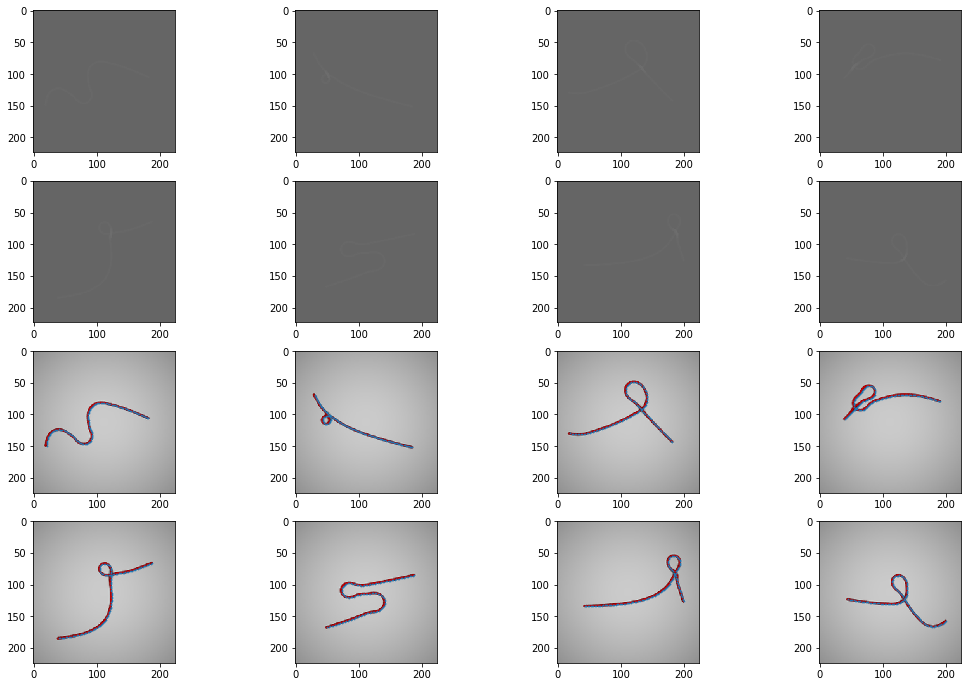

In [39]:
w = 4
h = 2
fig = plt.figure(figsize=(18, 12))
# fig2 = plt.figure(figsize=(12, 8))


for i, img_features in enumerate(train_pds.take(w * h)):
    i += 1
    depth = tf.io.decode_raw(img_features['depth_raw'], tf.uint8)
    rgb = tf.io.decode_raw(img_features['img_raw'], tf.uint8)
    height = tf.cast(img_features['height'], tf.int32)
    width = tf.cast(img_features['width'], tf.int32)
    depth = tf.reshape(depth, tf.stack([width, height, 3]))
    depth = tf.cast(depth, dtype=tf.float32)
    rgb = tf.reshape(rgb, tf.stack([width, height, 3]))
    rgb = tf.cast(rgb, dtype=tf.float32)
    position = tf.reshape(img_features['position'], tf.constant([2,128]))
#     position = tf.transpose(position)
#     intersect = img_features['intersect'] + 1
#     intersect = tf.one_hot(intersect, depth=3)
#     has_intersection = img_features['has_intersection']
#     print(has_intersection)

    scale = np.eye(3)
    scale[0, 0] = -width/2
    scale[1, 1] = -height/2
    
    trans = np.eye(3)
    trans[0, 2] = width/2
    trans[1, 2] = height/2

    pos_np = np.vstack((position.numpy()/6, np.ones((1, 128))))
    pos_np = trans @ scale @ pos_np

    fig.add_subplot(2 * h, w, i)
    plt.imshow(depth.numpy()/256)
    fig.add_subplot(2 * h, w, w*h+i)
    plt.imshow(rgb.numpy()/256)
    plt.scatter(pos_np[0, :], pos_np[1, :], s=.5)

    
#     fig.add_subplot(3 * h, w, 2*w*h+i)
#     plt.scatter(pos_np[])

train_total = 0
intersections = 0
for i, img_features in enumerate(train_pds):
    train_total = i + 1
    intersections += img_features['has_intersection'].numpy()
    
print(train_total)
print("Training Intersections Percentage", intersections/train_total)

val_total = 0
intersections = 0
for i, img_features in enumerate(val_ds.map(_parse_img_function)):
    val_total = i + 1
    intersections += img_features['has_intersection'].numpy()
    
print(val_total)
print("Validation Intersections Percentage", intersections/val_total)

test_total = 0
intersections = 0
for i, img_features in enumerate(test_ds.map(_parse_img_function)):
    test_total = i + 1
    intersections += img_features['has_intersection'].numpy()
    
print(test_total)
print("Validation Intersections Percentage", intersections/test_total)

In [102]:
def _parse_img_function_for_position(example_proto):
    out = tf.io.parse_single_example(example_proto, image_feature_description)
    img = tf.io.decode_raw(out['img_raw'], tf.uint8)
    height = tf.cast(out['height'], tf.int32)
    width = tf.cast(out['width'], tf.int32)
    img = tf.reshape(img, tf.stack([width, height, 3]))
    img = tf.cast(img, dtype=tf.float32)
    
    position = tf.reshape(out['position'], tf.constant([2,128]))
    position = tf.transpose(position)
    position = tf.reshape(position, [-1])
    
#     has_intersection = tf.one_hot(tf.cast(out['has_intersection'], tf.uint8), 2)
    return img, position

AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 20

train = train_ds.map(_parse_img_function_for_position)
train = train.shuffle(9000)
train = train.batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=AUTOTUNE)

val = val_ds.map(_parse_img_function_for_position)
val = val.batch(BATCH_SIZE)
val = val.prefetch(buffer_size=AUTOTUNE)

test = test_ds.map(_parse_img_function_for_position)
test = test.batch(1)
test = test.prefetch(buffer_size=AUTOTUNE)

## Building a Model

Below is a modified version of VGG 16. I use VGG 16 weights and have a few fully connected layers after to capture class probabilities.

In [146]:
weight_dict = np.load('vgg16_weights.npz')
# print(weight_dict.files)

In [147]:
VGG_MEAN = [103.939, 116.779, 123.68]

class POS_RGB(tf.keras.Model):
    def __init__(self, vgg16_npy_path, num_classes, load_weights=True):
        super(POS_RGB, self).__init__()
        
        self.load_weight = load_weights
        
        if self.load_weight:
            self.weight_data = np.load(vgg16_npy_path)
            
#             self.conv1_1 = self._build_conv_layer('conv1_1', 64)
#             self.conv1_2 = self._build_conv_layer('conv1_2', 64)
#             self.pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
            
#             self.conv2_1 = self._build_conv_layer('conv2_1', 128)
#             self.conv2_2 = self._build_conv_layer('conv2_2', 128)
#             self.pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
            
#             self.conv3_1 = self._build_conv_layer('conv3_1', 256)
#             self.conv3_2 = self._build_conv_layer('conv3_2', 256)
#             self.conv3_3 = self._build_conv_layer('conv3_3', 256)
#             self.pool3 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')

#             self.conv4_1 = self._build_conv_layer('conv4_1', 512)
#             self.conv4_2 = self._build_conv_layer('conv4_2', 512)
#             self.conv4_3 = self._build_conv_layer('conv4_3', 512)
#             self.pool4 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
            
#             self.conv5_1 = self._build_conv_layer('conv5_1', 512)
#             self.conv5_2 = self._build_conv_layer('conv5_2', 512)
#             self.conv5_3 = self._build_conv_layer('conv5_3', 512)
#             self.pool5 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
                        
            self.conv6_1 = self._build_conv_layer('conv6_1', 64, load_weight=False, trainable=True, reg=tf.keras.regularizers.l2(1e-2))
            self.bn6_1 = tf.keras.layers.BatchNormalization()
            self.pool6_1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
#             self.drop6 = tf.keras.layers.Dropout(0.3)
            self.conv6_2 = self._build_conv_layer('conv6_2', 128, load_weight=False, trainable=True, reg=tf.keras.regularizers.l2(1e-2))
            self.bn6_2 = tf.keras.layers.BatchNormalization()
            self.pool6_2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
            self.conv6_3 = self._build_conv_layer('conv6_3', 64, load_weight=False, trainable=True, reg=tf.keras.regularizers.l2(1e-2))
            self.bn6_3 = tf.keras.layers.BatchNormalization()
            self.pool6_3 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
            
            self.flatten = tf.keras.layers.Flatten()
            
            self.fc6 = self._build_dense_layer('fc6', 1024, tf.keras.activations.relu)
            self.fc7 = self._build_dense_layer('fc7', 1024, tf.keras.activations.relu)
#             self.fc8 = self._build_dense_layer('fc8', 128, tf.keras.activations.relu)
#             self.fc9 = self._build_dense_layer('fc9', 128, tf.keras.activations.relu)
            self.fc10 = self._build_dense_layer('fc10', num_classes, None)
            
#             self.fc8 = self.dense('fc8', 128, tf.keras.layers.ReLU)
#             self.fc9 = self.denes('fc9', 128, tf.keras)

    def call(self, x, training=False):
        scores = None
        
#         print(x.shape)
        x = tf.reverse(x, axis=[-1]) - tf.constant(VGG_MEAN)
        x = x / 256.0

#         x = self.conv1_1(x)
#         x = self.conv1_2(x)
#         x = self.pool1(x)
#         x = self.conv2_1(x)
#         x = self.conv2_2(x)
#         x = self.pool2(x)
#         x = self.conv3_1(x)
#         x = self.conv3_2(x)
#         x = self.pool3(x)
#         x = self.conv4_1(x)
#         x = self.conv4_2(x)
#         x = self.conv4_3(x)
#         x = self.pool4(x)
#         x = self.conv5_1(x)
#         x = self.conv5_2(x)
#         x = self.conv5_3(x)
#         x = self.pool5(x)
#         print(x.shape)
        x = self.conv6_1(x)
#         print(x.shape)
        x = self.bn6_1(x)
#         print(x.shape)
#         x = self.drop6(x)
        x = self.pool6_1(x)
        x = self.conv6_2(x)
#         print(x.shape)
        x = self.bn6_2(x)
#         print(x.shape)
        x = self.pool6_2(x)
        x = self.conv6_3(x)
#         print(x.shape)  
        x = self.bn6_3(x)
#         print(x.shape)
        x = self.pool6_3(x)
#         print(x.shape)
        x = self.flatten(x)
#         print(x.shape)        
        x = self.fc6(x)
        x = self.fc7(x)
#         x = self.fc8(x)
#         x = self.fc9(x)
        scores = self.fc10(x)
#         print(scores.shape)
#         print(scores)
        
        return scores
    
    def _build_conv_layer(self, name, filters, load_weight=True, kernel=3, stride=(1, 1), trainable=False, reg=None):
        if load_weight:
            k_init = tf.constant_initializer(self.weight_data[name + '_W'])
            b_init = tf.constant_initializer(self.weight_data[name + '_b'])
        else:
            k_init = tf.initializers.he_normal()
            b_init = tf.initializers.zeros()
        
        conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel, strides=stride, padding='same',
                                      activation=tf.keras.activations.relu, kernel_initializer=k_init, bias_initializer=b_init,
                                      trainable=trainable, kernel_regularizer=reg)        
        return conv
        
    
    def _build_dense_layer(self, name, hidden_dim, activation, scale=1.0, load_weight=False, trainable=True):
        if load_weight:
            k_init = tf.constant_initializer(self.weight_data[name + '_W'])
            b_init = tf.constant_initializer(self.weight_data[name + '_b'])
        else:
            k_init = tf.keras.initializers.he_normal()
            b_init = tf.initializers.zeros()
        
        dense = tf.keras.layers.Dense(hidden_dim, activation=activation, kernel_initializer=k_init, 
                                      bias_initializer=b_init, trainable=trainable)
        
        return dense


In [148]:
def test_posrgb():
    model = POS_RGB('vgg16_weights.npz', 256)
    print(device)
    with tf.device(device):
        x = tf.random.uniform((64, 224, 224, 3))
        scores = model(x)
        print(scores.shape)
#         print(scores)

test_posrgb()

/device:GPU:0
(64, 256)


In [149]:
model = POS_RGB('vgg16_weights.npz', 256)

model.compile(#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=True),
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.mean_squared_error,
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.mean_squared_error, tf.keras.metrics.mean_absolute_error])

#     print(model.summary())

cp_callback = tf.keras.callbacks.ModelCheckpoint('model-checkpoint/cp.ckpt',
                                                 monitor='acc', 
                                                 verbose=1,
                                                 mode='max')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, 
                                             write_graph=True, write_images=True,
                                             update_freq='batch')

history = model.fit(
                    train,
                    steps_per_epoch=9000//BATCH_SIZE,
                    epochs=10,
                    verbose=1,
                    validation_data=val,
                    validation_steps=6,
                    validation_freq=1,
                    callbacks = [cp_callback, tb_callback]
            )

print('\nhistory dict', history.history)

print('\n# Evaluate on test data')
results = model.evaluate(test)
print('test loss, test acc:', results)

Epoch 1/10
449/450 [============================>.] - ETA: 0s - loss: 5.0305 - mean_squared_error: 1.5395 - mean_absolute_error: 0.9011
Epoch 00001: saving model to model-checkpoint/cp.ckpt
450/450 [==============================] - 58s 128ms/step - loss: 5.0277 - mean_squared_error: 1.5363 - mean_absolute_error: 0.9000 - val_loss: 4.5560 - val_mean_squared_error: 1.2955 - val_mean_absolute_error: 0.9368
Epoch 2/10
449/450 [============================>.] - ETA: 0s - loss: 2.8654 - mean_squared_error: 0.3331 - mean_absolute_error: 0.4410
Epoch 00002: saving model to model-checkpoint/cp.ckpt
450/450 [==============================] - 50s 110ms/step - loss: 2.8640 - mean_squared_error: 0.3330 - mean_absolute_error: 0.4409 - val_loss: 2.3232 - val_mean_squared_error: 0.3455 - val_mean_absolute_error: 0.4638
Epoch 3/10
449/450 [============================>.] - ETA: 0s - loss: 1.8031 - mean_squared_error: 0.2223 - mean_absolute_error: 0.3616
Epoch 00003: saving model to model-checkpoint/cp

In [152]:
print('Generate predictions for all samples')

# bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# the bool below corresponds to the real state
# correct_no_intersection = []
# correct_yes_intersection = []
# incorrect_no_intersection = []
# incorrect_yes_intersection = []

prediction_results = []

for i, sample in enumerate(test):
    pred = model.predict(sample[0])
#     print(pred)
    mse = np.mean((pred - sample[1])**2)        
    
    prediction_results.append([sample[0], pred, mse])

# for sample in test:
#     pred = model.predict(sample[0])
#     pred = tf.keras.activations.softmax(tf.convert_to_tensor(pred))
#     one_hot = tf.one_hot(tf.math.argmax(pred, axis=1), 2)
#     if np.array_equal(one_hot.numpy(), sample[1].numpy()):
#         if sample[1].numpy()[0][0] == 1:
#             correct_no_intersection.append(sample[0])
#         else:
#             correct_yes_intersection.append(sample[0])
#     else:
#         if sample[1].numpy()[0][0] == 1:
#             incorrect_no_intersection.append(sample[0])
#         else:
#             incorrect_yes_intersection.append(sample[0])


Generate predictions for all samples


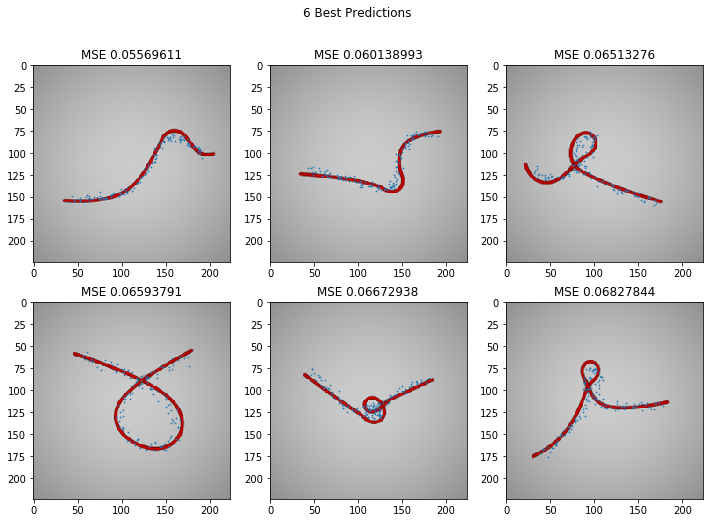

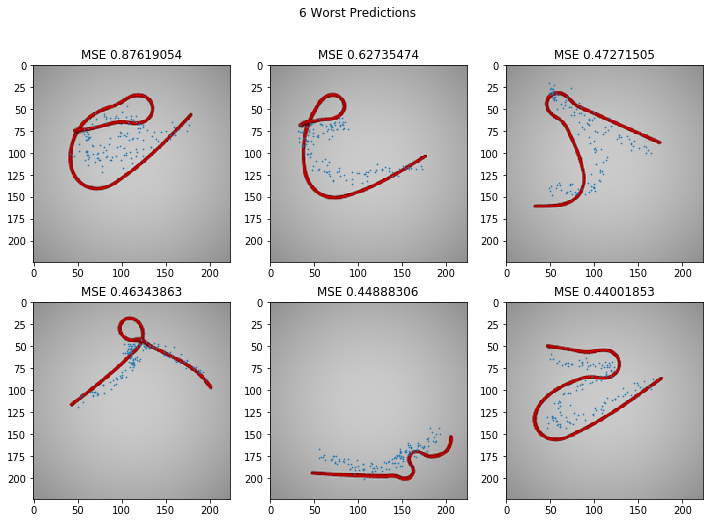

In [153]:
import random

def plot_preds(preds, w, h):
    preds.sort(key = lambda x: x[2])
    fig = plt.figure(figsize=(4 * w, 4 * h))
    fig.suptitle(str(w * h) + " Best Predictions")

    for i in range(w * h):
        good = preds[i]
        rgb = tf.squeeze(good[0])
        position = good[1]
        mse = good[2]
        
        position = tf.reshape(position, tf.constant([128, 2]))
        position = tf.transpose(position)

        scale = np.eye(3)
        scale[0, 0] = -width/2
        scale[1, 1] = -height/2

        trans = np.eye(3)
        trans[0, 2] = width/2
        trans[1, 2] = height/2

        pos_np = np.vstack((position.numpy()/6, np.ones((1, 128))))
        pos_np = trans @ scale @ pos_np
        
        ax =fig.add_subplot(h, w, i + 1)
        ax.set_title("MSE " + str(mse))
        plt.imshow(rgb.numpy()/256)
        plt.scatter(pos_np[0, :], pos_np[1, :], s=.5)
    
    fig = plt.figure(figsize=(4 * w, 4 * h))
    fig.suptitle(str(w * h) + " Worst Predictions")
    
    for i in range(w * h):
        bad = preds[-i-1]
        rgb = tf.squeeze(bad[0])
        position = bad[1]
        mse = bad[2]
        
        position = tf.reshape(position, tf.constant([128, 2]))
        position = tf.transpose(position)

        scale = np.eye(3)
        scale[0, 0] = -width/2
        scale[1, 1] = -height/2

        trans = np.eye(3)
        trans[0, 2] = width/2
        trans[1, 2] = height/2

        pos_np = np.vstack((position.numpy()/6, np.ones((1, 128))))
        pos_np = trans @ scale @ pos_np
        
        ax =fig.add_subplot(h, w, i + 1)
        ax.set_title("MSE " + str(mse))
        plt.imshow(rgb.numpy()/256)
        plt.scatter(pos_np[0, :], pos_np[1, :], s=.5)

plot_preds(prediction_results, 3, 2)
# print(len(correct_no_intersection))
# total = len(correct_no_intersection) + len(correct_yes_intersection) + len(incorrect_no_intersection) + len(incorrect_yes_intersection)
# plot_random_preds(correct_no_intersection, 3, 2, 'Correctly Classified No Intersections', total)
# plot_random_preds(correct_yes_intersection, 3, 2, 'Correctly Classified Intersections', total)
# plot_random_preds(incorrect_no_intersection, 3, 2, 'Incorrectly Classified No Intersections', total)
# plot_random_preds(incorrect_yes_intersection, 3, 2, 'Incorrectly Classified Intersections', total)
# print(len(correct_no_intersection))

